# Convolutional Networks

In [1]:
# Setup
import tensorflow as tf
import keras

import time as timer
import datetime

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import dataset

### Constants

In [2]:
EPOCH = 20
BATCH = 64

DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODELDIR = "/Users/mghifary/Work/Code/AI/models"

modelpath = os.path.join(MODELDIR, "fashion_mnist-lenet-classifier_temp2.h5")

In [3]:
# Load dataset
(x_train, y_train), (x_test, y_test) = dataset.load_data()

(n_train, dx1, dx2) = x_train.shape
n_test = x_test.shape[0]

ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Preprocess
ds_train = dataset.preprocess_fashionmnist(ds_train, shuffle=True, augment=False, batch_size=BATCH)
ds_test = dataset.preprocess_fashionmnist(ds_test, shuffle=False, augment=False, batch_size=BATCH)

In [4]:
def visualize_dataset(dataset, title="Untitled", n_samples=9):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)

    # decide subplot dimension
    d = np.sqrt(n_samples)
    d = np.ceil(d).astype("uint8")

    for i, samples in enumerate(iter(dataset.take(n_samples))):
        images = samples[0]
        plt.subplot(d, d, i + 1)
        img = images[0].numpy()
        vmin = np.min(img)
        vmax = np.max(img)
        plt.imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
        plt.axis("off")
    plt.show()

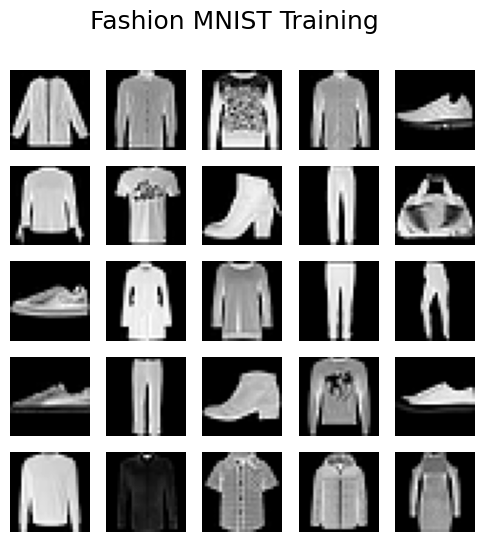

In [5]:
# Visualize training samples
visualize_dataset(ds_train, title="Fashion MNIST Training", n_samples=25)

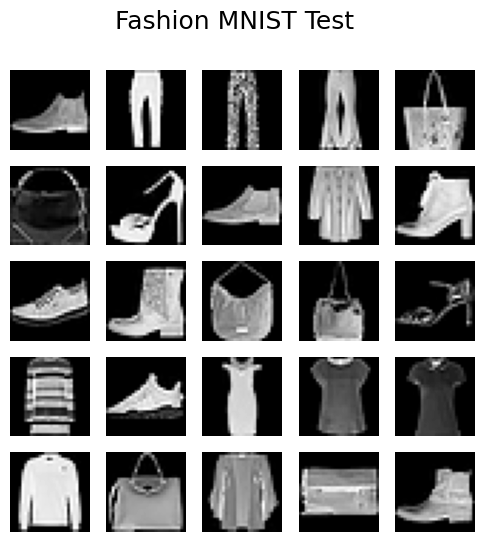

In [6]:
# Visualize test samples
visualize_dataset(ds_test, title="Fashion MNIST Test", n_samples=25)

In [7]:
# Build model

# LeNet5
inputs = keras.Input(shape=(dx1, dx2, 1))
x = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D((2, 2))(x)

x = keras.layers.Conv2D(48, kernel_size=(5, 5), padding="valid")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D((2, 2))(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(10)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="fashion_mnist_lenet5")
model.summary()



Model: "fashion_mnist_lenet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 batch_normalization_1 (Bat  (None, 10, 10, 48

In [8]:
# # Build model
# class LeNet5(keras.Sequential):
#     """LeNet5 architecture"""

#     def __init__(self, num_classes=10):
#         super().__init__()
#         self.add(keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same", input_shape=(dx1, dx2, 1)))
#         self.add(keras.layers.BatchNormalization())
#         # self.add(keras.layers.ReLU())
#         self.add(keras.layers.MaxPool2D((2, 2)))

#         self.add(keras.layers.Conv2D(48, kernel_size=(5, 5), padding="valid"))
#         self.add(keras.layers.BatchNormalization())
#         # self.add(keras.layers.ReLU())
#         self.add(keras.layers.MaxPool2D((2, 2)))

#         self.add(keras.layers.Flatten())

#         self.add(keras.layers.Dense(256, activation="relu"))
#         self.add(keras.layers.Dense(128, activation="relu"))
#         self.add(keras.layers.Dense(num_classes))

# model = LeNet5(num_classes=10)
# model.build(input_shape=(None, dx1, dx2))
# model.summary()

Train model

In [9]:
# Loss and optimizer
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.legacy.Adam(learning_rate=3e-4)


In [10]:
# Define metrics
train_loss = keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = keras.metrics.SparseCategoricalAccuracy('train_accuracy')

test_loss = keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [11]:
# Training and test function
@tf.function
def train_on_batch(model, loss_fn, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss_value = loss_fn(y, y_pred)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_loss(loss_value)
    train_accuracy(y, y_pred)

@tf.function
def test_on_batch(model, loss_fn, x, y):
    y_pred = model(x, training=False)
    loss_value = loss_fn(y, y_pred)
    
    test_loss(loss_value)
    test_accuracy(y, y_pred)

In [12]:
# Setup summary writers
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/convnet-fashionmnist/' + current_time + '/train'
test_log_dir = 'logs/convnet-fashionmnist/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [13]:
# Do training
for epoch in range(EPOCH):
    # Mini-batch training
    train_duration = 0.0
    for step, (x, y) in enumerate(ds_train):
        start_t = timer.time()
        train_on_batch(model, loss_fn, optimizer, x, y)
        elapsed_t = timer.time() - start_t

        train_duration += elapsed_t
    
    # Store log
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

    # Test
    test_duration = 0.0
    for step, (xt, yt) in enumerate(ds_test):
        start_t = timer.time()
        test_on_batch(model, loss_fn, xt, yt)
        elapsed_t = timer.time() - start_t

        test_duration += elapsed_t

    # Store log
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

    print(f"Epoch {epoch+1} - Training [loss: {train_loss.result():.5f}, accuracy: {train_accuracy.result():.3f}] ({train_duration:.3f} secs), Test [loss: {test_loss.result():.5f}. accuracy: {test_accuracy.result():.3f}] ({test_duration:.3f} secs)")

    # Save model
    model.save_weights(modelpath, overwrite=True, save_format=None, options=None)

# end of epoch

Epoch 1 - Training [loss: 0.42120, accuracy: 0.849] (15.004 secs), Test [loss: 0.34418. accuracy: 0.876] (0.973 secs)
Epoch 2 - Training [loss: 0.35371, accuracy: 0.873] (14.780 secs), Test [loss: 0.32465. accuracy: 0.881] (0.795 secs)
Epoch 3 - Training [loss: 0.31562, accuracy: 0.886] (14.604 secs), Test [loss: 0.31076. accuracy: 0.886] (0.791 secs)
Epoch 4 - Training [loss: 0.28848, accuracy: 0.896] (14.779 secs), Test [loss: 0.30061. accuracy: 0.889] (0.813 secs)
Epoch 5 - Training [loss: 0.26634, accuracy: 0.903] (15.717 secs), Test [loss: 0.29990. accuracy: 0.890] (0.817 secs)
Epoch 6 - Training [loss: 0.24774, accuracy: 0.910] (15.495 secs), Test [loss: 0.29667. accuracy: 0.892] (0.878 secs)
Epoch 7 - Training [loss: 0.23112, accuracy: 0.916] (15.481 secs), Test [loss: 0.29514. accuracy: 0.894] (0.831 secs)
Epoch 8 - Training [loss: 0.21648, accuracy: 0.921] (16.583 secs), Test [loss: 0.29468. accuracy: 0.896] (0.921 secs)
Epoch 9 - Training [loss: 0.20323, accuracy: 0.926] (16.